In [1]:
# https://www.youtube.com/watch?v=Y1qxI-Df4Lk
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [2]:
import torch
torch.cuda.set_device(3)
print(torch.cuda.is_available())
print(os.environ["CUDA_VISIBLE_DEVICES"])
print("Current device:", torch.cuda.current_device())
print("Device count:", torch.cuda.device_count())

True
0, 1, 2, 3
Current device: 3
Device count: 4


In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dir = '../cat_faces'
print(os.listdir(dir))

['cats']


In [5]:
image_size = 64
# image_size = 256
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

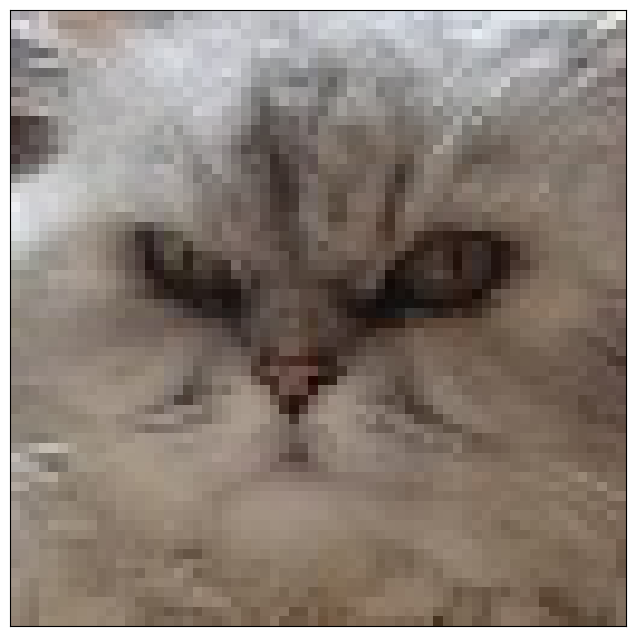

In [8]:
show_images(train_ds[0][0])

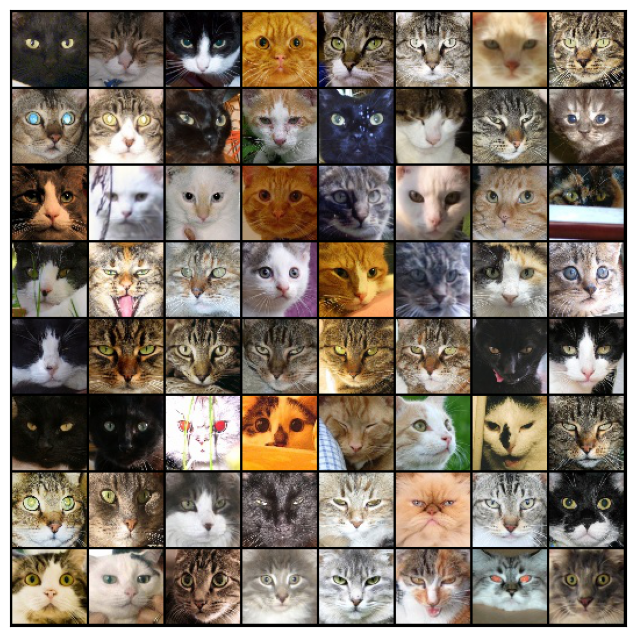

In [9]:
show_batch(train_dl)

In [10]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device=is_cuda_available()
# device = torch.device("cuda")
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [11]:
# basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

# discriminator = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 64 x 64

#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 32 x 32

#     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 16 x 16

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 8 x 8

#     nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 1024 x 4 x 4

#     nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator, device)

In [13]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)
# latent_size = 256
# generator = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out: 1024 x 4 x 4
    
#     nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out: 512 x 8 x 8

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # out: 256 x 16 x 16

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # out: 128 x 32 x 32

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # out: 64 x 64 x 64

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 128 x 128
# )

In [14]:
generator = to_device(generator, device)

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
#Tests

In [20]:
# xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [21]:
import numpy
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
numpy.shape(fixed_latent)

torch.Size([64, 128, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


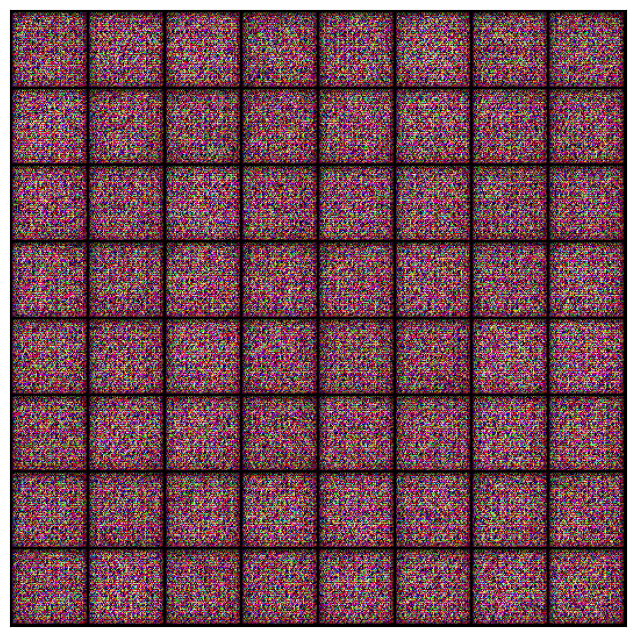

In [22]:
save_samples(0, fixed_latent)

In [23]:
#Tests

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_d = torch.optim.SGD(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.SGD(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [27]:
lr = 0.0003
# epochs = 60
epochs = 1000

In [28]:
history=fit(epochs,lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/1000], loss_g: 3.1560, loss_d: 1.4385, real_score: 0.9104, fake_score: 0.7091
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/1000], loss_g: 4.2903, loss_d: 1.4871, real_score: 0.7004, fake_score: 0.5191
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/1000], loss_g: 1.8388, loss_d: 0.9188, real_score: 0.6226, fake_score: 0.3226
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/1000], loss_g: 4.2719, loss_d: 0.3794, real_score: 0.8359, fake_score: 0.1685
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/1000], loss_g: 2.7465, loss_d: 0.5051, real_score: 0.7037, fake_score: 0.1303
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/1000], loss_g: 3.3296, loss_d: 0.3724, real_score: 0.8857, fake_score: 0.2123
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/1000], loss_g: 6.3157, loss_d: 0.9923, real_score: 0.9679, fake_score: 0.5720
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/1000], loss_g: 4.5884, loss_d: 0.5014, real_score: 0.9862, fake_score: 0.3576
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/1000], loss_g: 2.8125, loss_d: 0.8356, real_score: 0.6452, fake_score: 0.2780
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/1000], loss_g: 2.8478, loss_d: 0.6351, real_score: 0.7078, fake_score: 0.2061
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/1000], loss_g: 1.5963, loss_d: 1.2547, real_score: 0.4663, fake_score: 0.0643
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/1000], loss_g: 7.4408, loss_d: 1.1632, real_score: 0.8698, fake_score: 0.6026
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/1000], loss_g: 3.6988, loss_d: 0.1866, real_score: 0.8924, fake_score: 0.0620
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/1000], loss_g: 2.8893, loss_d: 0.0974, real_score: 0.9986, fake_score: 0.0892
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/1000], loss_g: 3.1603, loss_d: 2.6017, real_score: 0.1418, fake_score: 0.0041
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/1000], loss_g: 6.2394, loss_d: 0.7168, real_score: 0.7955, fake_score: 0.3466
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/1000], loss_g: 4.6393, loss_d: 0.0977, real_score: 0.9761, fake_score: 0.0684
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/1000], loss_g: 4.0158, loss_d: 0.0420, real_score: 0.9762, fake_score: 0.0175
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/1000], loss_g: 3.5006, loss_d: 0.4190, real_score: 0.8393, fake_score: 0.1993
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/1000], loss_g: 6.8772, loss_d: 0.3860, real_score: 0.9807, fake_score: 0.2715
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/1000], loss_g: 3.0644, loss_d: 0.1312, real_score: 0.9975, fake_score: 0.1149
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/1000], loss_g: 2.4295, loss_d: 1.8421, real_score: 0.2062, fake_score: 0.0093
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/1000], loss_g: 2.7348, loss_d: 0.3522, real_score: 0.8101, fake_score: 0.1247
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/1000], loss_g: 5.3615, loss_d: 0.1172, real_score: 0.9584, fake_score: 0.0671
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/1000], loss_g: 0.8524, loss_d: 1.3008, real_score: 0.3992, fake_score: 0.0083
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/1000], loss_g: 6.0187, loss_d: 0.0541, real_score: 0.9511, fake_score: 0.0031
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/1000], loss_g: 10.4747, loss_d: 0.7398, real_score: 0.5055, fake_score: 0.0001
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/1000], loss_g: 2.1022, loss_d: 1.0442, real_score: 0.4519, fake_score: 0.0219
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/1000], loss_g: 5.9147, loss_d: 0.2877, real_score: 0.9884, fake_score: 0.2188
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/1000], loss_g: 4.8496, loss_d: 0.2555, real_score: 0.9518, fake_score: 0.1653
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/1000], loss_g: 5.0454, loss_d: 0.2410, real_score: 0.8441, fake_score: 0.0356
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/1000], loss_g: 8.0010, loss_d: 3.8443, real_score: 0.0342, fake_score: 0.0000
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/1000], loss_g: 8.7509, loss_d: 0.0188, real_score: 0.9837, fake_score: 0.0023
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/1000], loss_g: 4.2070, loss_d: 0.1200, real_score: 0.9132, fake_score: 0.0270
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/1000], loss_g: 5.4521, loss_d: 0.0624, real_score: 0.9966, fake_score: 0.0548
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/1000], loss_g: 4.3538, loss_d: 0.2836, real_score: 0.8221, fake_score: 0.0801
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/1000], loss_g: 5.1513, loss_d: 0.2694, real_score: 0.9455, fake_score: 0.1720
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/1000], loss_g: 5.3279, loss_d: 0.1468, real_score: 0.8858, fake_score: 0.0105
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/1000], loss_g: 10.4517, loss_d: 0.5580, real_score: 0.9998, fake_score: 0.3618
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/1000], loss_g: 1.3346, loss_d: 0.5904, real_score: 0.6855, fake_score: 0.0309
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/1000], loss_g: 5.6816, loss_d: 0.4559, real_score: 0.9427, fake_score: 0.2665
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/1000], loss_g: 1.6311, loss_d: 0.7488, real_score: 0.5666, fake_score: 0.1250
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/1000], loss_g: 2.8012, loss_d: 0.3752, real_score: 0.7523, fake_score: 0.0288
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/1000], loss_g: 5.0455, loss_d: 0.2459, real_score: 0.8206, fake_score: 0.0139
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/1000], loss_g: 5.7247, loss_d: 0.2004, real_score: 0.8804, fake_score: 0.0553
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/1000], loss_g: 5.0001, loss_d: 0.0360, real_score: 0.9965, fake_score: 0.0311
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/1000], loss_g: 5.5654, loss_d: 0.8092, real_score: 0.7524, fake_score: 0.2833
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/1000], loss_g: 5.7284, loss_d: 0.0630, real_score: 0.9794, fake_score: 0.0394
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/1000], loss_g: 7.6402, loss_d: 0.2137, real_score: 0.9843, fake_score: 0.1639
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/1000], loss_g: 0.9568, loss_d: 0.8509, real_score: 0.5276, fake_score: 0.0337
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/1000], loss_g: 0.8055, loss_d: 1.2018, real_score: 0.4779, fake_score: 0.0736
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/1000], loss_g: 5.5249, loss_d: 0.1278, real_score: 0.9159, fake_score: 0.0323
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/1000], loss_g: 3.3832, loss_d: 0.1843, real_score: 0.8851, fake_score: 0.0533
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/1000], loss_g: 5.9323, loss_d: 0.3556, real_score: 0.9385, fake_score: 0.2239
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/1000], loss_g: 0.5720, loss_d: 1.3348, real_score: 0.3635, fake_score: 0.1331
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/1000], loss_g: 0.4010, loss_d: 0.8378, real_score: 0.5139, fake_score: 0.1202
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/1000], loss_g: 4.1951, loss_d: 0.2647, real_score: 0.9161, fake_score: 0.1484
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/1000], loss_g: 1.3915, loss_d: 0.9420, real_score: 0.5834, fake_score: 0.2305
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/1000], loss_g: 0.4522, loss_d: 1.3591, real_score: 0.4241, fake_score: 0.0458
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/1000], loss_g: 0.0642, loss_d: 0.8778, real_score: 0.4668, fake_score: 0.0577
Saving generated-images-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [61/1000], loss_g: 7.1525, loss_d: 0.3897, real_score: 0.9853, fake_score: 0.2604
Saving generated-images-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [62/1000], loss_g: 3.0658, loss_d: 0.1562, real_score: 0.9123, fake_score: 0.0558
Saving generated-images-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [63/1000], loss_g: 0.0233, loss_d: 1.2672, real_score: 0.3011, fake_score: 0.0309
Saving generated-images-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [64/1000], loss_g: 1.0173, loss_d: 0.9021, real_score: 0.5884, fake_score: 0.2386
Saving generated-images-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [65/1000], loss_g: 1.6503, loss_d: 0.4376, real_score: 0.7380, fake_score: 0.0744
Saving generated-images-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [66/1000], loss_g: 6.8363, loss_d: 0.3804, real_score: 0.9841, fake_score: 0.2532
Saving generated-images-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [67/1000], loss_g: 5.2858, loss_d: 0.1569, real_score: 0.9894, fake_score: 0.1204
Saving generated-images-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [68/1000], loss_g: 0.4139, loss_d: 1.0245, real_score: 0.4677, fake_score: 0.2015
Saving generated-images-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [69/1000], loss_g: 2.7306, loss_d: 0.3740, real_score: 0.7264, fake_score: 0.0268
Saving generated-images-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [70/1000], loss_g: 0.8416, loss_d: 1.9985, real_score: 0.2272, fake_score: 0.0070
Saving generated-images-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [71/1000], loss_g: 0.0933, loss_d: 1.2800, real_score: 0.4669, fake_score: 0.2684
Saving generated-images-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [72/1000], loss_g: 1.7820, loss_d: 0.4780, real_score: 0.7590, fake_score: 0.1369
Saving generated-images-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [73/1000], loss_g: 0.1052, loss_d: 1.0006, real_score: 0.4229, fake_score: 0.0601
Saving generated-images-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [74/1000], loss_g: 4.5112, loss_d: 0.1617, real_score: 0.9721, fake_score: 0.1141
Saving generated-images-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [75/1000], loss_g: 1.0008, loss_d: 0.5092, real_score: 0.7613, fake_score: 0.1733
Saving generated-images-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [76/1000], loss_g: 3.0118, loss_d: 0.2845, real_score: 0.8712, fake_score: 0.1090
Saving generated-images-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [77/1000], loss_g: 0.0099, loss_d: 2.2139, real_score: 0.2202, fake_score: 0.1167
Saving generated-images-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [78/1000], loss_g: 1.0757, loss_d: 0.5273, real_score: 0.6961, fake_score: 0.0857
Saving generated-images-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [79/1000], loss_g: 2.9647, loss_d: 0.9012, real_score: 0.7995, fake_score: 0.4012
Saving generated-images-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [80/1000], loss_g: 3.8120, loss_d: 0.3505, real_score: 0.9446, fake_score: 0.2219
Saving generated-images-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [81/1000], loss_g: 5.5725, loss_d: 0.3017, real_score: 0.9756, fake_score: 0.2126
Saving generated-images-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [82/1000], loss_g: 0.8569, loss_d: 1.0865, real_score: 0.5155, fake_score: 0.1501
Saving generated-images-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [83/1000], loss_g: 4.7127, loss_d: 0.1384, real_score: 0.9932, fake_score: 0.1152
Saving generated-images-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [84/1000], loss_g: 0.0367, loss_d: 1.5490, real_score: 0.2337, fake_score: 0.0410
Saving generated-images-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [85/1000], loss_g: 0.3962, loss_d: 0.7131, real_score: 0.6468, fake_score: 0.1868
Saving generated-images-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [86/1000], loss_g: 1.1926, loss_d: 0.4141, real_score: 0.7509, fake_score: 0.0919
Saving generated-images-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [87/1000], loss_g: 0.1366, loss_d: 0.9140, real_score: 0.4465, fake_score: 0.0717
Saving generated-images-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [88/1000], loss_g: 0.0913, loss_d: 1.4330, real_score: 0.3953, fake_score: 0.0531
Saving generated-images-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [89/1000], loss_g: 3.1282, loss_d: 0.6480, real_score: 0.7359, fake_score: 0.1842
Saving generated-images-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [90/1000], loss_g: 0.2453, loss_d: 1.0624, real_score: 0.5165, fake_score: 0.1192
Saving generated-images-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [91/1000], loss_g: 0.2983, loss_d: 1.3438, real_score: 0.3816, fake_score: 0.0718
Saving generated-images-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [92/1000], loss_g: 1.5692, loss_d: 0.3240, real_score: 0.8100, fake_score: 0.0896
Saving generated-images-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [93/1000], loss_g: 1.7043, loss_d: 0.3662, real_score: 0.7697, fake_score: 0.0907
Saving generated-images-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [94/1000], loss_g: 4.5785, loss_d: 0.3989, real_score: 0.8701, fake_score: 0.1816
Saving generated-images-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [95/1000], loss_g: 0.2959, loss_d: 0.7509, real_score: 0.5945, fake_score: 0.0395
Saving generated-images-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [96/1000], loss_g: 3.6209, loss_d: 0.4274, real_score: 0.8435, fake_score: 0.1785
Saving generated-images-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [97/1000], loss_g: 0.0030, loss_d: 2.2192, real_score: 0.1275, fake_score: 0.0968
Saving generated-images-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [98/1000], loss_g: 0.2677, loss_d: 1.0542, real_score: 0.3955, fake_score: 0.0998
Saving generated-images-0098.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [99/1000], loss_g: 4.0813, loss_d: 0.1205, real_score: 0.9673, fake_score: 0.0776
Saving generated-images-0099.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [100/1000], loss_g: 0.4097, loss_d: 0.7820, real_score: 0.5174, fake_score: 0.0591
Saving generated-images-0100.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [101/1000], loss_g: 8.3153, loss_d: 0.9730, real_score: 0.9978, fake_score: 0.5082
Saving generated-images-0101.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [102/1000], loss_g: 0.1682, loss_d: 4.9710, real_score: 0.0462, fake_score: 0.0044
Saving generated-images-0102.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [103/1000], loss_g: 3.8713, loss_d: 0.7194, real_score: 0.7639, fake_score: 0.2712
Saving generated-images-0103.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [104/1000], loss_g: 0.7451, loss_d: 0.7246, real_score: 0.5869, fake_score: 0.1385
Saving generated-images-0104.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [105/1000], loss_g: 3.5975, loss_d: 0.2599, real_score: 0.9188, fake_score: 0.1460
Saving generated-images-0105.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [106/1000], loss_g: 3.0120, loss_d: 0.2081, real_score: 0.8789, fake_score: 0.0653
Saving generated-images-0106.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [107/1000], loss_g: 0.1462, loss_d: 1.1129, real_score: 0.3989, fake_score: 0.0237
Saving generated-images-0107.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [108/1000], loss_g: 3.2602, loss_d: 0.2105, real_score: 0.9308, fake_score: 0.1164
Saving generated-images-0108.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [109/1000], loss_g: 1.9491, loss_d: 0.4741, real_score: 0.7228, fake_score: 0.1008
Saving generated-images-0109.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [110/1000], loss_g: 5.0069, loss_d: 0.1740, real_score: 0.9000, fake_score: 0.0555
Saving generated-images-0110.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [111/1000], loss_g: 2.2051, loss_d: 0.2216, real_score: 0.8534, fake_score: 0.0494
Saving generated-images-0111.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [112/1000], loss_g: 5.4239, loss_d: 0.2108, real_score: 0.9970, fake_score: 0.1632
Saving generated-images-0112.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [113/1000], loss_g: 1.5260, loss_d: 0.9135, real_score: 0.4305, fake_score: 0.0268
Saving generated-images-0113.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [114/1000], loss_g: 0.0179, loss_d: 1.6361, real_score: 0.2913, fake_score: 0.0281
Saving generated-images-0114.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [115/1000], loss_g: 0.5273, loss_d: 0.5437, real_score: 0.6365, fake_score: 0.0745
Saving generated-images-0115.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [116/1000], loss_g: 2.2885, loss_d: 0.3092, real_score: 0.7762, fake_score: 0.0403
Saving generated-images-0116.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [117/1000], loss_g: 0.1555, loss_d: 1.0761, real_score: 0.3745, fake_score: 0.0775
Saving generated-images-0117.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [118/1000], loss_g: 3.6645, loss_d: 0.1761, real_score: 0.8916, fake_score: 0.0459
Saving generated-images-0118.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [119/1000], loss_g: 4.7596, loss_d: 0.0531, real_score: 0.9682, fake_score: 0.0198
Saving generated-images-0119.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [120/1000], loss_g: 3.4167, loss_d: 0.3435, real_score: 0.8656, fake_score: 0.1391
Saving generated-images-0120.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [121/1000], loss_g: 5.7499, loss_d: 0.1507, real_score: 0.9993, fake_score: 0.1226
Saving generated-images-0121.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [122/1000], loss_g: 1.7981, loss_d: 0.5652, real_score: 0.6753, fake_score: 0.0441
Saving generated-images-0122.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [123/1000], loss_g: 2.7256, loss_d: 0.2710, real_score: 0.8553, fake_score: 0.0771
Saving generated-images-0123.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [124/1000], loss_g: 3.8028, loss_d: 0.2406, real_score: 0.9175, fake_score: 0.1236
Saving generated-images-0124.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [125/1000], loss_g: 3.5190, loss_d: 0.2909, real_score: 0.9014, fake_score: 0.1479
Saving generated-images-0125.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [126/1000], loss_g: 6.3393, loss_d: 0.2017, real_score: 0.9405, fake_score: 0.0813
Saving generated-images-0126.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [127/1000], loss_g: 0.0414, loss_d: 1.9391, real_score: 0.1852, fake_score: 0.0619
Saving generated-images-0127.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [128/1000], loss_g: 2.0469, loss_d: 0.4980, real_score: 0.6577, fake_score: 0.0397
Saving generated-images-0128.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [129/1000], loss_g: 0.9176, loss_d: 0.3500, real_score: 0.7469, fake_score: 0.0526
Saving generated-images-0129.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [130/1000], loss_g: 4.1667, loss_d: 0.1912, real_score: 0.8673, fake_score: 0.0436
Saving generated-images-0130.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [131/1000], loss_g: 4.4177, loss_d: 0.1212, real_score: 0.9605, fake_score: 0.0745
Saving generated-images-0131.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [132/1000], loss_g: 0.5870, loss_d: 1.0994, real_score: 0.4713, fake_score: 0.0535
Saving generated-images-0132.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [133/1000], loss_g: 0.7882, loss_d: 0.5039, real_score: 0.6712, fake_score: 0.0646
Saving generated-images-0133.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [134/1000], loss_g: 2.7652, loss_d: 0.1919, real_score: 0.8893, fake_score: 0.0601
Saving generated-images-0134.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [135/1000], loss_g: 4.3004, loss_d: 0.2131, real_score: 0.9008, fake_score: 0.0887
Saving generated-images-0135.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [136/1000], loss_g: 1.2981, loss_d: 1.1268, real_score: 0.5530, fake_score: 0.1464
Saving generated-images-0136.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [137/1000], loss_g: 0.4059, loss_d: 0.8114, real_score: 0.5348, fake_score: 0.0342
Saving generated-images-0137.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [138/1000], loss_g: 4.6025, loss_d: 0.0931, real_score: 0.9487, fake_score: 0.0372
Saving generated-images-0138.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [139/1000], loss_g: 0.0222, loss_d: 4.4939, real_score: 0.0123, fake_score: 0.0225
Saving generated-images-0139.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [140/1000], loss_g: 0.4140, loss_d: 0.9827, real_score: 0.4605, fake_score: 0.1118
Saving generated-images-0140.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [141/1000], loss_g: 0.7465, loss_d: 1.0876, real_score: 0.5262, fake_score: 0.0982
Saving generated-images-0141.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [142/1000], loss_g: 4.2289, loss_d: 0.4000, real_score: 0.8947, fake_score: 0.1925
Saving generated-images-0142.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [143/1000], loss_g: 0.1064, loss_d: 2.8148, real_score: 0.1071, fake_score: 0.0657
Saving generated-images-0143.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [144/1000], loss_g: 1.1051, loss_d: 0.4949, real_score: 0.6975, fake_score: 0.0645
Saving generated-images-0144.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [145/1000], loss_g: 1.3443, loss_d: 0.4919, real_score: 0.6795, fake_score: 0.0468
Saving generated-images-0145.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [146/1000], loss_g: 0.1627, loss_d: 2.0666, real_score: 0.1333, fake_score: 0.0236
Saving generated-images-0146.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [147/1000], loss_g: 4.6545, loss_d: 0.1174, real_score: 0.9811, fake_score: 0.0831
Saving generated-images-0147.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [148/1000], loss_g: 0.0930, loss_d: 4.4440, real_score: 0.0188, fake_score: 0.0602
Saving generated-images-0148.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [149/1000], loss_g: 0.3609, loss_d: 0.8692, real_score: 0.5469, fake_score: 0.1063
Saving generated-images-0149.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [150/1000], loss_g: 0.0820, loss_d: 3.4294, real_score: 0.0608, fake_score: 0.0389
Saving generated-images-0150.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [151/1000], loss_g: 4.3836, loss_d: 0.2517, real_score: 0.9777, fake_score: 0.1697
Saving generated-images-0151.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [152/1000], loss_g: 1.2875, loss_d: 0.5438, real_score: 0.6556, fake_score: 0.0621
Saving generated-images-0152.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [153/1000], loss_g: 3.0604, loss_d: 0.2194, real_score: 0.8535, fake_score: 0.0400
Saving generated-images-0153.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [154/1000], loss_g: 1.0064, loss_d: 0.9627, real_score: 0.5393, fake_score: 0.0115
Saving generated-images-0154.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [155/1000], loss_g: 0.0457, loss_d: 2.4024, real_score: 0.1333, fake_score: 0.0294
Saving generated-images-0155.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [156/1000], loss_g: 4.4712, loss_d: 0.2188, real_score: 0.9740, fake_score: 0.1488
Saving generated-images-0156.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [157/1000], loss_g: 0.6333, loss_d: 0.7030, real_score: 0.6253, fake_score: 0.0736
Saving generated-images-0157.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [158/1000], loss_g: 4.5859, loss_d: 0.1026, real_score: 0.9623, fake_score: 0.0527
Saving generated-images-0158.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [159/1000], loss_g: 0.3006, loss_d: 1.1689, real_score: 0.3388, fake_score: 0.0212
Saving generated-images-0159.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [160/1000], loss_g: 3.4052, loss_d: 0.1959, real_score: 0.8490, fake_score: 0.0227
Saving generated-images-0160.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [161/1000], loss_g: 0.8358, loss_d: 1.5605, real_score: 0.3959, fake_score: 0.0193
Saving generated-images-0161.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [162/1000], loss_g: 0.4490, loss_d: 0.9924, real_score: 0.4780, fake_score: 0.0777
Saving generated-images-0162.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [163/1000], loss_g: 0.2317, loss_d: 0.9243, real_score: 0.4551, fake_score: 0.0810
Saving generated-images-0163.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [164/1000], loss_g: 5.3186, loss_d: 0.0685, real_score: 0.9817, fake_score: 0.0440
Saving generated-images-0164.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [165/1000], loss_g: 0.0736, loss_d: 3.8663, real_score: 0.0870, fake_score: 0.0210
Saving generated-images-0165.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [166/1000], loss_g: 0.6601, loss_d: 1.5082, real_score: 0.3027, fake_score: 0.0681
Saving generated-images-0166.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [167/1000], loss_g: 0.1750, loss_d: 2.1601, real_score: 0.1808, fake_score: 0.0672
Saving generated-images-0167.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [168/1000], loss_g: 4.0405, loss_d: 0.1045, real_score: 0.9545, fake_score: 0.0521
Saving generated-images-0168.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [169/1000], loss_g: 0.6873, loss_d: 1.0762, real_score: 0.4421, fake_score: 0.0611
Saving generated-images-0169.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [170/1000], loss_g: 3.2569, loss_d: 0.3511, real_score: 0.7218, fake_score: 0.0151
Saving generated-images-0170.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [171/1000], loss_g: 0.4155, loss_d: 0.7956, real_score: 0.4886, fake_score: 0.0217
Saving generated-images-0171.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [172/1000], loss_g: 0.0997, loss_d: 1.6371, real_score: 0.2317, fake_score: 0.0211
Saving generated-images-0172.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [173/1000], loss_g: 1.3355, loss_d: 0.8526, real_score: 0.5701, fake_score: 0.0408
Saving generated-images-0173.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [174/1000], loss_g: 2.7744, loss_d: 0.1930, real_score: 0.8453, fake_score: 0.0203
Saving generated-images-0174.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [175/1000], loss_g: 5.8058, loss_d: 0.0636, real_score: 0.9971, fake_score: 0.0555
Saving generated-images-0175.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [176/1000], loss_g: 0.0108, loss_d: 5.7533, real_score: 0.0034, fake_score: 0.0363
Saving generated-images-0176.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [177/1000], loss_g: 1.2328, loss_d: 0.7619, real_score: 0.6461, fake_score: 0.0379
Saving generated-images-0177.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [178/1000], loss_g: 4.3541, loss_d: 0.0721, real_score: 0.9848, fake_score: 0.0495
Saving generated-images-0178.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [179/1000], loss_g: 0.4584, loss_d: 1.4985, real_score: 0.3822, fake_score: 0.0159
Saving generated-images-0179.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [180/1000], loss_g: 4.4587, loss_d: 0.1362, real_score: 0.8984, fake_score: 0.0157
Saving generated-images-0180.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [181/1000], loss_g: 1.2350, loss_d: 0.3946, real_score: 0.7417, fake_score: 0.0672
Saving generated-images-0181.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [182/1000], loss_g: 0.1894, loss_d: 0.9903, real_score: 0.4114, fake_score: 0.0245
Saving generated-images-0182.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [183/1000], loss_g: 0.4080, loss_d: 2.3378, real_score: 0.3354, fake_score: 0.0237
Saving generated-images-0183.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [184/1000], loss_g: 1.9713, loss_d: 0.4053, real_score: 0.7087, fake_score: 0.0191
Saving generated-images-0184.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [185/1000], loss_g: 0.2518, loss_d: 2.1295, real_score: 0.2546, fake_score: 0.0541
Saving generated-images-0185.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [186/1000], loss_g: 4.5716, loss_d: 0.1624, real_score: 0.9264, fake_score: 0.0687
Saving generated-images-0186.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [187/1000], loss_g: 1.6112, loss_d: 0.6319, real_score: 0.6346, fake_score: 0.0250
Saving generated-images-0187.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [188/1000], loss_g: 5.1587, loss_d: 0.0348, real_score: 0.9914, fake_score: 0.0248
Saving generated-images-0188.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [189/1000], loss_g: 2.2701, loss_d: 0.3909, real_score: 0.7628, fake_score: 0.0565
Saving generated-images-0189.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [190/1000], loss_g: 8.8259, loss_d: 0.7188, real_score: 0.9525, fake_score: 0.4050
Saving generated-images-0190.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [191/1000], loss_g: 0.0429, loss_d: 3.0243, real_score: 0.0628, fake_score: 0.0289
Saving generated-images-0191.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [192/1000], loss_g: 0.4168, loss_d: 2.3215, real_score: 0.2406, fake_score: 0.0569
Saving generated-images-0192.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [193/1000], loss_g: 0.7929, loss_d: 2.3529, real_score: 0.3359, fake_score: 0.0660
Saving generated-images-0193.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [194/1000], loss_g: 0.3711, loss_d: 1.4104, real_score: 0.4099, fake_score: 0.0889
Saving generated-images-0194.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [195/1000], loss_g: 0.6889, loss_d: 1.2722, real_score: 0.4391, fake_score: 0.0581
Saving generated-images-0195.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [196/1000], loss_g: 0.7425, loss_d: 1.0701, real_score: 0.4312, fake_score: 0.1017
Saving generated-images-0196.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [197/1000], loss_g: 5.1732, loss_d: 0.0397, real_score: 0.9935, fake_score: 0.0317
Saving generated-images-0197.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [198/1000], loss_g: 1.2225, loss_d: 0.5433, real_score: 0.6541, fake_score: 0.0503
Saving generated-images-0198.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [199/1000], loss_g: 1.8565, loss_d: 0.8263, real_score: 0.6089, fake_score: 0.0572
Saving generated-images-0199.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [200/1000], loss_g: 1.1931, loss_d: 0.7273, real_score: 0.5821, fake_score: 0.0499
Saving generated-images-0200.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [201/1000], loss_g: 3.9562, loss_d: 0.1865, real_score: 0.8674, fake_score: 0.0274
Saving generated-images-0201.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [202/1000], loss_g: 0.1215, loss_d: 1.5967, real_score: 0.2617, fake_score: 0.0240
Saving generated-images-0202.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [203/1000], loss_g: 2.2896, loss_d: 0.4007, real_score: 0.7502, fake_score: 0.0224
Saving generated-images-0203.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [204/1000], loss_g: 1.1285, loss_d: 0.4760, real_score: 0.6712, fake_score: 0.0124
Saving generated-images-0204.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [205/1000], loss_g: 5.5061, loss_d: 0.0204, real_score: 0.9999, fake_score: 0.0196
Saving generated-images-0205.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [206/1000], loss_g: 0.1646, loss_d: 2.7513, real_score: 0.2287, fake_score: 0.0504
Saving generated-images-0206.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [207/1000], loss_g: 5.6314, loss_d: 0.0894, real_score: 0.9829, fake_score: 0.0636
Saving generated-images-0207.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [208/1000], loss_g: 0.3713, loss_d: 0.6255, real_score: 0.5820, fake_score: 0.0477
Saving generated-images-0208.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [209/1000], loss_g: 4.2378, loss_d: 0.1013, real_score: 0.9623, fake_score: 0.0564
Saving generated-images-0209.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [210/1000], loss_g: 0.1878, loss_d: 1.8979, real_score: 0.2377, fake_score: 0.0487
Saving generated-images-0210.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [211/1000], loss_g: 0.0255, loss_d: 3.1430, real_score: 0.0516, fake_score: 0.0558
Saving generated-images-0211.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [212/1000], loss_g: 1.4647, loss_d: 0.6776, real_score: 0.6120, fake_score: 0.0374
Saving generated-images-0212.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [213/1000], loss_g: 0.9211, loss_d: 1.0855, real_score: 0.4528, fake_score: 0.0602
Saving generated-images-0213.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [214/1000], loss_g: 4.1014, loss_d: 0.1662, real_score: 0.8740, fake_score: 0.0253
Saving generated-images-0214.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [215/1000], loss_g: 0.0811, loss_d: 1.6940, real_score: 0.2252, fake_score: 0.0426
Saving generated-images-0215.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [216/1000], loss_g: 1.4806, loss_d: 0.9120, real_score: 0.5851, fake_score: 0.0338
Saving generated-images-0216.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [217/1000], loss_g: 0.5546, loss_d: 0.4798, real_score: 0.6762, fake_score: 0.0508
Saving generated-images-0217.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [218/1000], loss_g: 2.7456, loss_d: 0.5058, real_score: 0.7303, fake_score: 0.0218
Saving generated-images-0218.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [219/1000], loss_g: 0.4282, loss_d: 1.1999, real_score: 0.3477, fake_score: 0.0283
Saving generated-images-0219.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [220/1000], loss_g: 0.3024, loss_d: 3.6821, real_score: 0.1600, fake_score: 0.0302
Saving generated-images-0220.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [221/1000], loss_g: 0.6280, loss_d: 3.0639, real_score: 0.1209, fake_score: 0.0197
Saving generated-images-0221.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [222/1000], loss_g: 0.2138, loss_d: 1.3483, real_score: 0.3557, fake_score: 0.0702
Saving generated-images-0222.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [223/1000], loss_g: 4.9212, loss_d: 0.1396, real_score: 0.9654, fake_score: 0.0852
Saving generated-images-0223.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [224/1000], loss_g: 2.5158, loss_d: 0.2564, real_score: 0.8090, fake_score: 0.0369
Saving generated-images-0224.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [225/1000], loss_g: 0.8022, loss_d: 0.8513, real_score: 0.5609, fake_score: 0.0222
Saving generated-images-0225.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [226/1000], loss_g: 1.8875, loss_d: 0.2527, real_score: 0.8317, fake_score: 0.0577
Saving generated-images-0226.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [227/1000], loss_g: 6.3818, loss_d: 0.0428, real_score: 0.9888, fake_score: 0.0295
Saving generated-images-0227.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [228/1000], loss_g: 0.2924, loss_d: 1.5242, real_score: 0.2879, fake_score: 0.0323
Saving generated-images-0228.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [229/1000], loss_g: 5.5127, loss_d: 0.0542, real_score: 0.9896, fake_score: 0.0398
Saving generated-images-0229.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [230/1000], loss_g: 2.2372, loss_d: 0.2673, real_score: 0.8176, fake_score: 0.0264
Saving generated-images-0230.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [231/1000], loss_g: 0.1648, loss_d: 2.1882, real_score: 0.2339, fake_score: 0.0567
Saving generated-images-0231.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [232/1000], loss_g: 0.4418, loss_d: 0.8260, real_score: 0.4733, fake_score: 0.0413
Saving generated-images-0232.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [233/1000], loss_g: 3.6032, loss_d: 0.3223, real_score: 0.7887, fake_score: 0.0613
Saving generated-images-0233.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [234/1000], loss_g: 4.3031, loss_d: 0.1192, real_score: 0.9507, fake_score: 0.0553
Saving generated-images-0234.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [235/1000], loss_g: 1.1514, loss_d: 0.7938, real_score: 0.5907, fake_score: 0.0256
Saving generated-images-0235.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [236/1000], loss_g: 4.5697, loss_d: 0.1101, real_score: 0.9946, fake_score: 0.0914
Saving generated-images-0236.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [237/1000], loss_g: 2.2713, loss_d: 0.1780, real_score: 0.8910, fake_score: 0.0554
Saving generated-images-0237.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [238/1000], loss_g: 3.8621, loss_d: 0.0728, real_score: 0.9792, fake_score: 0.0461
Saving generated-images-0238.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [239/1000], loss_g: 0.2713, loss_d: 1.0022, real_score: 0.4810, fake_score: 0.0163
Saving generated-images-0239.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [240/1000], loss_g: 4.0892, loss_d: 0.2618, real_score: 0.7906, fake_score: 0.0159
Saving generated-images-0240.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [241/1000], loss_g: 3.9342, loss_d: 0.1515, real_score: 0.8882, fake_score: 0.0272
Saving generated-images-0241.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [242/1000], loss_g: 5.9187, loss_d: 0.0243, real_score: 0.9873, fake_score: 0.0111
Saving generated-images-0242.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [243/1000], loss_g: 0.0347, loss_d: 4.4049, real_score: 0.0426, fake_score: 0.0197
Saving generated-images-0243.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [244/1000], loss_g: 0.3857, loss_d: 4.6917, real_score: 0.1592, fake_score: 0.0458
Saving generated-images-0244.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [245/1000], loss_g: 4.4451, loss_d: 0.1509, real_score: 0.8927, fake_score: 0.0283
Saving generated-images-0245.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [246/1000], loss_g: 4.5202, loss_d: 0.1671, real_score: 0.8823, fake_score: 0.0226
Saving generated-images-0246.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [247/1000], loss_g: 0.2993, loss_d: 3.1104, real_score: 0.0681, fake_score: 0.0104
Saving generated-images-0247.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [248/1000], loss_g: 0.6041, loss_d: 2.7524, real_score: 0.2831, fake_score: 0.0217
Saving generated-images-0248.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [249/1000], loss_g: 1.1699, loss_d: 0.7519, real_score: 0.5490, fake_score: 0.0460
Saving generated-images-0249.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [250/1000], loss_g: 0.1761, loss_d: 2.0988, real_score: 0.2324, fake_score: 0.0683
Saving generated-images-0250.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [251/1000], loss_g: 3.9738, loss_d: 0.1045, real_score: 0.9588, fake_score: 0.0533
Saving generated-images-0251.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [252/1000], loss_g: 4.4145, loss_d: 0.1815, real_score: 0.9700, fake_score: 0.1178
Saving generated-images-0252.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [253/1000], loss_g: 3.8220, loss_d: 0.1400, real_score: 0.8828, fake_score: 0.0082
Saving generated-images-0253.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [254/1000], loss_g: 0.2276, loss_d: 1.2293, real_score: 0.3267, fake_score: 0.0221
Saving generated-images-0254.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [255/1000], loss_g: 2.7904, loss_d: 0.4213, real_score: 0.7851, fake_score: 0.1081
Saving generated-images-0255.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [256/1000], loss_g: 1.3101, loss_d: 0.4911, real_score: 0.6649, fake_score: 0.0225
Saving generated-images-0256.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [257/1000], loss_g: 6.5677, loss_d: 0.0313, real_score: 0.9852, fake_score: 0.0157
Saving generated-images-0257.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [258/1000], loss_g: 0.4887, loss_d: 2.0270, real_score: 0.1479, fake_score: 0.0089
Saving generated-images-0258.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [259/1000], loss_g: 0.7552, loss_d: 1.3349, real_score: 0.4962, fake_score: 0.0243
Saving generated-images-0259.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [260/1000], loss_g: 3.5242, loss_d: 0.1729, real_score: 0.8600, fake_score: 0.0172
Saving generated-images-0260.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [261/1000], loss_g: 0.2514, loss_d: 2.6998, real_score: 0.0901, fake_score: 0.0483
Saving generated-images-0261.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [262/1000], loss_g: 0.0860, loss_d: 1.8913, real_score: 0.1676, fake_score: 0.0423
Saving generated-images-0262.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [263/1000], loss_g: 0.1665, loss_d: 3.7579, real_score: 0.0680, fake_score: 0.0358
Saving generated-images-0263.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [264/1000], loss_g: 5.5306, loss_d: 0.2305, real_score: 0.9138, fake_score: 0.0933
Saving generated-images-0264.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [265/1000], loss_g: 1.8902, loss_d: 0.5009, real_score: 0.6874, fake_score: 0.0644
Saving generated-images-0265.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [266/1000], loss_g: 6.4904, loss_d: 0.0444, real_score: 0.9787, fake_score: 0.0213
Saving generated-images-0266.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [267/1000], loss_g: 1.4351, loss_d: 0.8642, real_score: 0.4973, fake_score: 0.0221
Saving generated-images-0267.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [268/1000], loss_g: 0.2515, loss_d: 2.4003, real_score: 0.0960, fake_score: 0.0279
Saving generated-images-0268.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [269/1000], loss_g: 2.3819, loss_d: 0.3986, real_score: 0.7315, fake_score: 0.0369
Saving generated-images-0269.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [270/1000], loss_g: 4.7468, loss_d: 0.0363, real_score: 0.9949, fake_score: 0.0292
Saving generated-images-0270.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [271/1000], loss_g: 5.1040, loss_d: 0.0373, real_score: 0.9971, fake_score: 0.0313
Saving generated-images-0271.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [272/1000], loss_g: 4.9849, loss_d: 0.0592, real_score: 0.9645, fake_score: 0.0213
Saving generated-images-0272.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [273/1000], loss_g: 5.8659, loss_d: 0.0525, real_score: 0.9653, fake_score: 0.0161
Saving generated-images-0273.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [274/1000], loss_g: 0.2464, loss_d: 1.7097, real_score: 0.2884, fake_score: 0.0389
Saving generated-images-0274.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [275/1000], loss_g: 5.9882, loss_d: 0.0331, real_score: 0.9964, fake_score: 0.0267
Saving generated-images-0275.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [276/1000], loss_g: 5.1295, loss_d: 0.1077, real_score: 0.9384, fake_score: 0.0393
Saving generated-images-0276.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [277/1000], loss_g: 1.8069, loss_d: 0.2267, real_score: 0.8201, fake_score: 0.0229
Saving generated-images-0277.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [278/1000], loss_g: 0.2226, loss_d: 2.6424, real_score: 0.0868, fake_score: 0.0249
Saving generated-images-0278.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [279/1000], loss_g: 0.2323, loss_d: 1.4458, real_score: 0.2997, fake_score: 0.0345
Saving generated-images-0279.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [280/1000], loss_g: 4.6814, loss_d: 0.1096, real_score: 0.9339, fake_score: 0.0331
Saving generated-images-0280.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [281/1000], loss_g: 0.5704, loss_d: 1.8075, real_score: 0.2570, fake_score: 0.0244
Saving generated-images-0281.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [282/1000], loss_g: 1.0952, loss_d: 0.7247, real_score: 0.5400, fake_score: 0.0343
Saving generated-images-0282.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [283/1000], loss_g: 0.2930, loss_d: 2.1480, real_score: 0.2582, fake_score: 0.0251
Saving generated-images-0283.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [284/1000], loss_g: 2.4505, loss_d: 0.3187, real_score: 0.7997, fake_score: 0.0203
Saving generated-images-0284.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [285/1000], loss_g: 4.0669, loss_d: 0.0882, real_score: 0.9704, fake_score: 0.0524
Saving generated-images-0285.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [286/1000], loss_g: 1.3312, loss_d: 0.6170, real_score: 0.6206, fake_score: 0.0339
Saving generated-images-0286.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [287/1000], loss_g: 0.8681, loss_d: 1.2373, real_score: 0.4812, fake_score: 0.0385
Saving generated-images-0287.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [288/1000], loss_g: 1.3648, loss_d: 1.4035, real_score: 0.3639, fake_score: 0.0169
Saving generated-images-0288.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [289/1000], loss_g: 3.4005, loss_d: 0.3509, real_score: 0.7828, fake_score: 0.0413
Saving generated-images-0289.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [290/1000], loss_g: 0.2035, loss_d: 1.9744, real_score: 0.1601, fake_score: 0.0108
Saving generated-images-0290.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [291/1000], loss_g: 3.0865, loss_d: 0.1779, real_score: 0.8674, fake_score: 0.0218
Saving generated-images-0291.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [292/1000], loss_g: 6.2187, loss_d: 0.0171, real_score: 0.9998, fake_score: 0.0157
Saving generated-images-0292.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [293/1000], loss_g: 1.7776, loss_d: 0.4788, real_score: 0.6568, fake_score: 0.0298
Saving generated-images-0293.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [294/1000], loss_g: 4.3716, loss_d: 0.1255, real_score: 0.9035, fake_score: 0.0188
Saving generated-images-0294.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [295/1000], loss_g: 6.5122, loss_d: 0.0271, real_score: 0.9901, fake_score: 0.0164
Saving generated-images-0295.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [296/1000], loss_g: 3.0182, loss_d: 0.3846, real_score: 0.7563, fake_score: 0.0289
Saving generated-images-0296.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [297/1000], loss_g: 0.3001, loss_d: 3.1632, real_score: 0.2492, fake_score: 0.0182
Saving generated-images-0297.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [298/1000], loss_g: 2.5673, loss_d: 0.1458, real_score: 0.8980, fake_score: 0.0323
Saving generated-images-0298.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [299/1000], loss_g: 0.1632, loss_d: 2.2401, real_score: 0.2061, fake_score: 0.0674
Saving generated-images-0299.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [300/1000], loss_g: 1.8405, loss_d: 0.9431, real_score: 0.6310, fake_score: 0.0341
Saving generated-images-0300.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [301/1000], loss_g: 7.6013, loss_d: 0.3213, real_score: 0.9939, fake_score: 0.2118
Saving generated-images-0301.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [302/1000], loss_g: 2.6048, loss_d: 0.6034, real_score: 0.6926, fake_score: 0.0186
Saving generated-images-0302.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [303/1000], loss_g: 2.1759, loss_d: 0.2961, real_score: 0.7845, fake_score: 0.0262
Saving generated-images-0303.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [304/1000], loss_g: 5.0853, loss_d: 0.1125, real_score: 0.9678, fake_score: 0.0639
Saving generated-images-0304.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [305/1000], loss_g: 4.0138, loss_d: 0.1598, real_score: 0.8788, fake_score: 0.0243
Saving generated-images-0305.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [306/1000], loss_g: 0.6346, loss_d: 0.8068, real_score: 0.5161, fake_score: 0.0357
Saving generated-images-0306.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [307/1000], loss_g: 4.2709, loss_d: 0.2594, real_score: 0.8096, fake_score: 0.0057
Saving generated-images-0307.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [308/1000], loss_g: 4.3423, loss_d: 0.0521, real_score: 0.9795, fake_score: 0.0286
Saving generated-images-0308.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [309/1000], loss_g: 5.5148, loss_d: 0.0952, real_score: 0.9823, fake_score: 0.0620
Saving generated-images-0309.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [310/1000], loss_g: 6.2198, loss_d: 0.0837, real_score: 0.9847, fake_score: 0.0558
Saving generated-images-0310.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [311/1000], loss_g: 0.5292, loss_d: 0.6294, real_score: 0.5434, fake_score: 0.0105
Saving generated-images-0311.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [312/1000], loss_g: 2.8944, loss_d: 1.0276, real_score: 0.6506, fake_score: 0.1190
Saving generated-images-0312.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [313/1000], loss_g: 8.6241, loss_d: 0.0164, real_score: 0.9952, fake_score: 0.0099
Saving generated-images-0313.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [314/1000], loss_g: 0.1824, loss_d: 2.3706, real_score: 0.0970, fake_score: 0.0223
Saving generated-images-0314.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [315/1000], loss_g: 0.1182, loss_d: 2.0097, real_score: 0.2001, fake_score: 0.0592
Saving generated-images-0315.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [316/1000], loss_g: 4.6042, loss_d: 0.0824, real_score: 0.9571, fake_score: 0.0322
Saving generated-images-0316.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [317/1000], loss_g: 3.3498, loss_d: 0.1365, real_score: 0.9025, fake_score: 0.0228
Saving generated-images-0317.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [318/1000], loss_g: 1.9921, loss_d: 0.6969, real_score: 0.5894, fake_score: 0.0137
Saving generated-images-0318.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [319/1000], loss_g: 4.1400, loss_d: 0.1183, real_score: 0.9273, fake_score: 0.0340
Saving generated-images-0319.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [320/1000], loss_g: 0.5064, loss_d: 2.1032, real_score: 0.3174, fake_score: 0.0284
Saving generated-images-0320.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [321/1000], loss_g: 0.1676, loss_d: 1.1256, real_score: 0.3502, fake_score: 0.0414
Saving generated-images-0321.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [322/1000], loss_g: 2.1575, loss_d: 0.5416, real_score: 0.6419, fake_score: 0.0223
Saving generated-images-0322.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [323/1000], loss_g: 2.3822, loss_d: 0.4029, real_score: 0.7516, fake_score: 0.0358
Saving generated-images-0323.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [324/1000], loss_g: 5.3956, loss_d: 0.1192, real_score: 0.9051, fake_score: 0.0159
Saving generated-images-0324.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [325/1000], loss_g: 1.1462, loss_d: 0.6153, real_score: 0.6289, fake_score: 0.0410
Saving generated-images-0325.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [326/1000], loss_g: 7.1080, loss_d: 0.1070, real_score: 0.9581, fake_score: 0.0200
Saving generated-images-0326.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [327/1000], loss_g: 2.8431, loss_d: 0.3643, real_score: 0.7795, fake_score: 0.0296
Saving generated-images-0327.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [328/1000], loss_g: 1.8053, loss_d: 0.5399, real_score: 0.6487, fake_score: 0.0326
Saving generated-images-0328.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [329/1000], loss_g: 5.2240, loss_d: 0.0646, real_score: 0.9527, fake_score: 0.0133
Saving generated-images-0329.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [330/1000], loss_g: 6.7970, loss_d: 0.0741, real_score: 0.9526, fake_score: 0.0207
Saving generated-images-0330.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [331/1000], loss_g: 1.5015, loss_d: 0.5762, real_score: 0.6232, fake_score: 0.0133
Saving generated-images-0331.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [332/1000], loss_g: 5.2525, loss_d: 0.0772, real_score: 0.9672, fake_score: 0.0313
Saving generated-images-0332.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [333/1000], loss_g: 0.1883, loss_d: 2.5729, real_score: 0.0967, fake_score: 0.0119
Saving generated-images-0333.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [334/1000], loss_g: 2.7658, loss_d: 1.2573, real_score: 0.4713, fake_score: 0.0560
Saving generated-images-0334.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [335/1000], loss_g: 1.3246, loss_d: 0.3647, real_score: 0.7435, fake_score: 0.0522
Saving generated-images-0335.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [336/1000], loss_g: 2.7312, loss_d: 0.3375, real_score: 0.7728, fake_score: 0.0407
Saving generated-images-0336.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [337/1000], loss_g: 0.7900, loss_d: 0.9475, real_score: 0.4396, fake_score: 0.0229
Saving generated-images-0337.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [338/1000], loss_g: 0.1520, loss_d: 6.3096, real_score: 0.0216, fake_score: 0.0167
Saving generated-images-0338.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [339/1000], loss_g: 4.7636, loss_d: 0.1180, real_score: 0.9478, fake_score: 0.0554
Saving generated-images-0339.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [340/1000], loss_g: 2.6116, loss_d: 0.4467, real_score: 0.7521, fake_score: 0.0763
Saving generated-images-0340.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [341/1000], loss_g: 5.8457, loss_d: 0.2668, real_score: 0.8754, fake_score: 0.0692
Saving generated-images-0341.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [342/1000], loss_g: 4.8846, loss_d: 0.1563, real_score: 0.8991, fake_score: 0.0408
Saving generated-images-0342.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [343/1000], loss_g: 0.6913, loss_d: 2.6929, real_score: 0.2251, fake_score: 0.0151
Saving generated-images-0343.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [344/1000], loss_g: 4.1542, loss_d: 1.7278, real_score: 0.2748, fake_score: 0.0128
Saving generated-images-0344.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [345/1000], loss_g: 0.3889, loss_d: 0.8966, real_score: 0.5067, fake_score: 0.0518
Saving generated-images-0345.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [346/1000], loss_g: 0.5373, loss_d: 0.8366, real_score: 0.4551, fake_score: 0.0329
Saving generated-images-0346.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [347/1000], loss_g: 6.3554, loss_d: 0.0282, real_score: 0.9874, fake_score: 0.0147
Saving generated-images-0347.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [348/1000], loss_g: 0.2247, loss_d: 3.1071, real_score: 0.1144, fake_score: 0.0416
Saving generated-images-0348.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [349/1000], loss_g: 5.3290, loss_d: 0.0456, real_score: 0.9887, fake_score: 0.0284
Saving generated-images-0349.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [350/1000], loss_g: 0.3117, loss_d: 2.4117, real_score: 0.1646, fake_score: 0.0239
Saving generated-images-0350.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [351/1000], loss_g: 8.7057, loss_d: 0.1736, real_score: 0.9971, fake_score: 0.1253
Saving generated-images-0351.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [352/1000], loss_g: 1.9099, loss_d: 1.2689, real_score: 0.4663, fake_score: 0.0116
Saving generated-images-0352.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [353/1000], loss_g: 2.6945, loss_d: 0.4301, real_score: 0.6995, fake_score: 0.0273
Saving generated-images-0353.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [354/1000], loss_g: 0.1856, loss_d: 5.3921, real_score: 0.0124, fake_score: 0.0239
Saving generated-images-0354.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [355/1000], loss_g: 1.8227, loss_d: 0.8332, real_score: 0.6620, fake_score: 0.0596
Saving generated-images-0355.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [356/1000], loss_g: 5.7272, loss_d: 0.0330, real_score: 0.9955, fake_score: 0.0263
Saving generated-images-0356.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [357/1000], loss_g: 7.3474, loss_d: 0.0292, real_score: 0.9851, fake_score: 0.0133
Saving generated-images-0357.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [358/1000], loss_g: 0.4310, loss_d: 3.9620, real_score: 0.0510, fake_score: 0.0195
Saving generated-images-0358.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [359/1000], loss_g: 2.3948, loss_d: 0.7751, real_score: 0.5699, fake_score: 0.0244
Saving generated-images-0359.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [360/1000], loss_g: 5.6635, loss_d: 0.1559, real_score: 0.9999, fake_score: 0.1242
Saving generated-images-0360.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [361/1000], loss_g: 0.4231, loss_d: 2.7884, real_score: 0.1093, fake_score: 0.0103
Saving generated-images-0361.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [362/1000], loss_g: 0.1180, loss_d: 3.3008, real_score: 0.0667, fake_score: 0.1286
Saving generated-images-0362.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [363/1000], loss_g: 6.4705, loss_d: 0.0450, real_score: 0.9874, fake_score: 0.0248
Saving generated-images-0363.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [364/1000], loss_g: 2.2205, loss_d: 0.4379, real_score: 0.7259, fake_score: 0.0524
Saving generated-images-0364.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [365/1000], loss_g: 0.5033, loss_d: 1.0588, real_score: 0.4218, fake_score: 0.0408
Saving generated-images-0365.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [366/1000], loss_g: 0.4277, loss_d: 3.5429, real_score: 0.0406, fake_score: 0.0119
Saving generated-images-0366.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [367/1000], loss_g: 4.7832, loss_d: 0.4038, real_score: 0.7756, fake_score: 0.0303
Saving generated-images-0367.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [368/1000], loss_g: 5.1679, loss_d: 0.1249, real_score: 0.9147, fake_score: 0.0312
Saving generated-images-0368.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [369/1000], loss_g: 5.8115, loss_d: 0.0430, real_score: 0.9970, fake_score: 0.0323
Saving generated-images-0369.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [370/1000], loss_g: 6.8653, loss_d: 0.1198, real_score: 0.9977, fake_score: 0.0977
Saving generated-images-0370.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [371/1000], loss_g: 0.3882, loss_d: 3.5872, real_score: 0.0855, fake_score: 0.0590
Saving generated-images-0371.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [372/1000], loss_g: 2.1314, loss_d: 0.5938, real_score: 0.6335, fake_score: 0.0455
Saving generated-images-0372.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [373/1000], loss_g: 8.6737, loss_d: 0.0738, real_score: 0.9878, fake_score: 0.0518
Saving generated-images-0373.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [374/1000], loss_g: 7.0091, loss_d: 0.0365, real_score: 0.9834, fake_score: 0.0184
Saving generated-images-0374.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [375/1000], loss_g: 7.1437, loss_d: 0.0493, real_score: 0.9754, fake_score: 0.0220
Saving generated-images-0375.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [376/1000], loss_g: 0.9003, loss_d: 1.6612, real_score: 0.2679, fake_score: 0.0194
Saving generated-images-0376.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [377/1000], loss_g: 2.4785, loss_d: 2.4524, real_score: 0.4823, fake_score: 0.0195
Saving generated-images-0377.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [378/1000], loss_g: 2.8466, loss_d: 0.2655, real_score: 0.7914, fake_score: 0.0103
Saving generated-images-0378.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [379/1000], loss_g: 4.1934, loss_d: 0.3535, real_score: 0.8049, fake_score: 0.0641
Saving generated-images-0379.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [380/1000], loss_g: 1.6125, loss_d: 1.4469, real_score: 0.4272, fake_score: 0.0286
Saving generated-images-0380.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [381/1000], loss_g: 5.0862, loss_d: 0.0993, real_score: 0.9529, fake_score: 0.0445
Saving generated-images-0381.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [382/1000], loss_g: 7.1715, loss_d: 0.1520, real_score: 0.8667, fake_score: 0.0034
Saving generated-images-0382.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [383/1000], loss_g: 0.2908, loss_d: 1.7015, real_score: 0.2861, fake_score: 0.0276
Saving generated-images-0383.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [384/1000], loss_g: 1.1884, loss_d: 1.8490, real_score: 0.3965, fake_score: 0.0320
Saving generated-images-0384.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [385/1000], loss_g: 0.2178, loss_d: 3.8456, real_score: 0.0767, fake_score: 0.0319
Saving generated-images-0385.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [386/1000], loss_g: 1.9070, loss_d: 1.1995, real_score: 0.4136, fake_score: 0.0692
Saving generated-images-0386.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [387/1000], loss_g: 0.3771, loss_d: 3.5626, real_score: 0.0428, fake_score: 0.0544
Saving generated-images-0387.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [388/1000], loss_g: 5.9859, loss_d: 0.0484, real_score: 0.9783, fake_score: 0.0235
Saving generated-images-0388.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [389/1000], loss_g: 3.6829, loss_d: 0.5313, real_score: 0.7053, fake_score: 0.0252
Saving generated-images-0389.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [390/1000], loss_g: 2.9043, loss_d: 0.3278, real_score: 0.7499, fake_score: 0.0071
Saving generated-images-0390.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [391/1000], loss_g: 3.8772, loss_d: 0.1436, real_score: 0.8786, fake_score: 0.0104
Saving generated-images-0391.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [392/1000], loss_g: 8.0741, loss_d: 0.0189, real_score: 0.9988, fake_score: 0.0160
Saving generated-images-0392.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [393/1000], loss_g: 2.0028, loss_d: 1.1305, real_score: 0.5884, fake_score: 0.0158
Saving generated-images-0393.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [394/1000], loss_g: 2.9491, loss_d: 0.1473, real_score: 0.9170, fake_score: 0.0514
Saving generated-images-0394.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [395/1000], loss_g: 4.6751, loss_d: 0.2195, real_score: 0.8819, fake_score: 0.0659
Saving generated-images-0395.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [396/1000], loss_g: 5.9242, loss_d: 0.2770, real_score: 0.9183, fake_score: 0.1198
Saving generated-images-0396.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [397/1000], loss_g: 6.1525, loss_d: 0.0817, real_score: 0.9303, fake_score: 0.0080
Saving generated-images-0397.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [398/1000], loss_g: 2.4219, loss_d: 0.4660, real_score: 0.6571, fake_score: 0.0063
Saving generated-images-0398.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [399/1000], loss_g: 0.6131, loss_d: 3.2399, real_score: 0.3206, fake_score: 0.0176
Saving generated-images-0399.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [400/1000], loss_g: 5.5481, loss_d: 0.1536, real_score: 0.9431, fake_score: 0.0627
Saving generated-images-0400.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [401/1000], loss_g: 1.6641, loss_d: 0.3631, real_score: 0.7433, fake_score: 0.0380
Saving generated-images-0401.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [402/1000], loss_g: 0.0921, loss_d: 4.8715, real_score: 0.0082, fake_score: 0.0061
Saving generated-images-0402.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [403/1000], loss_g: 0.0665, loss_d: 4.8184, real_score: 0.0104, fake_score: 0.0135
Saving generated-images-0403.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [404/1000], loss_g: 0.2705, loss_d: 4.7804, real_score: 0.0369, fake_score: 0.0205
Saving generated-images-0404.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [405/1000], loss_g: 1.2199, loss_d: 4.9898, real_score: 0.0970, fake_score: 0.0092
Saving generated-images-0405.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [406/1000], loss_g: 3.0519, loss_d: 0.2754, real_score: 0.7948, fake_score: 0.0342
Saving generated-images-0406.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [407/1000], loss_g: 0.7310, loss_d: 2.8094, real_score: 0.1178, fake_score: 0.0449
Saving generated-images-0407.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [408/1000], loss_g: 4.8356, loss_d: 0.2566, real_score: 0.8744, fake_score: 0.0753
Saving generated-images-0408.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [409/1000], loss_g: 0.2929, loss_d: 1.5602, real_score: 0.3120, fake_score: 0.0223
Saving generated-images-0409.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [410/1000], loss_g: 6.2369, loss_d: 0.4223, real_score: 0.7623, fake_score: 0.0137
Saving generated-images-0410.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [411/1000], loss_g: 0.4949, loss_d: 2.4218, real_score: 0.1588, fake_score: 0.1917
Saving generated-images-0411.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [412/1000], loss_g: 2.8824, loss_d: 0.3732, real_score: 0.7639, fake_score: 0.0354
Saving generated-images-0412.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [413/1000], loss_g: 5.3270, loss_d: 0.1667, real_score: 0.8580, fake_score: 0.0117
Saving generated-images-0413.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [414/1000], loss_g: 4.9997, loss_d: 0.2483, real_score: 0.8581, fake_score: 0.0579
Saving generated-images-0414.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [415/1000], loss_g: 5.1893, loss_d: 0.0565, real_score: 0.9910, fake_score: 0.0425
Saving generated-images-0415.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [416/1000], loss_g: 6.3349, loss_d: 0.1018, real_score: 0.9349, fake_score: 0.0308
Saving generated-images-0416.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [417/1000], loss_g: 6.8323, loss_d: 0.0132, real_score: 0.9998, fake_score: 0.0126
Saving generated-images-0417.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [418/1000], loss_g: 1.2382, loss_d: 2.1276, real_score: 0.3525, fake_score: 0.0309
Saving generated-images-0418.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [419/1000], loss_g: 3.0066, loss_d: 0.1075, real_score: 0.9534, fake_score: 0.0529
Saving generated-images-0419.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [420/1000], loss_g: 0.5422, loss_d: 2.2599, real_score: 0.1748, fake_score: 0.0132
Saving generated-images-0420.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [421/1000], loss_g: 2.2002, loss_d: 0.5062, real_score: 0.6385, fake_score: 0.0150
Saving generated-images-0421.png


  0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

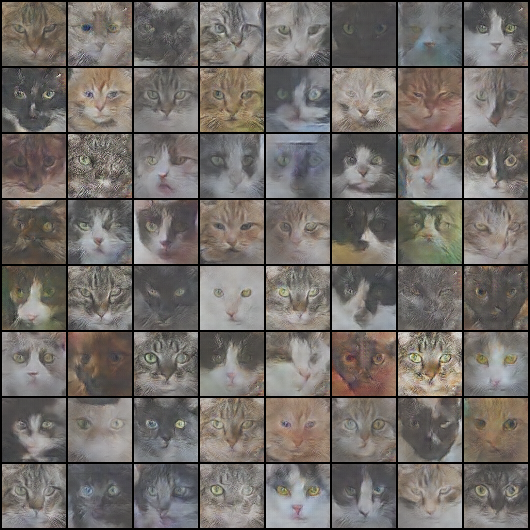

In [29]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')